In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvr
from scipy.stats import pearsonr as pr
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

digits = datasets.load_digits()
X=digits.data
y=digits.target

#get rid of constant columns
X = X[:, ~np.all(X[1:] == X[:-1], axis=0)]

#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.33, random_state=42)

We assume that the features follow a normal distribution and they are independent given  the label y
$$f(x) = \frac{1}{\sqrt{(2 \pi)^d \det \Sigma}}
         \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

# NaiveBayes Model

In [ ]:
# Create a class with fit, predict and scores methods with respect to Bayes approach

class NaiveBayes:
    
    # to make sure that fit gets called before predict
    fitted = False
    # to take in considerition whether there is negative labels
    present = False
    
    def fit(self, X, y, var_smoothing=1e-9): # add a smoothing parameter for calculus stability  
        
        # create a dictionoary for the parameters of the likelihood distrubtion
        self.params = {}
        
        # the prior distribution 
        self.priors = {}
        
        #get the set opf classes in the target variable y
        self.classes = list(sorted(set(y)))
        
        if -1 in self.classes:
            self.present = True
            
        
        for indx, c in enumerate(self.classes):
            
            # estimate the params of the likelyhood distribution
            x = X[y==c]
            self.params[indx] = {
                'mean': x.mean(axis=0),
                'variance': x.var(axis=0) + var_smoothing }   
            
            # compute the prior distribution
            self.priors[indx] = len(y[y==c])/len(y)
            
            self.fitted = True
            
            
    def predict(self, X):
        
        # raise an exception if this function is called before fittin the model
        if not self.fitted:
            raise Exception('The model need to be trained first')
        
        # get the n_rows in X:
        n = X.shape[0]
        
        # get the number of classes from the training
        k = len(self.params)
        
        # initiate matrix for the a postriori distribution (n*k)
        P = np.zeros((n, k), dtype = 'float')
        
        # compute the apostriori probability which is proportional to maxlikelyhood * priors
        for indx, prm in self.params.items():
            
            mean, var = prm['mean'], prm['variance']
            
            #we fill in the matrix by column
            P[:,indx] = mvr.pdf(X, mean = mean, cov = var)* self.priors[indx]
        
        # return the label (column number) with highest  apostriori value
        out = np.argmax(P, axis=1)
        
        if self.present:
            out[out == 0] = -1
            
        return out
    
                                
    def score(self, X, y):
        
        #predict classes
        y_pred = self.predict(X)
        
        #return the average of the instance that were correctly labled
        return np.mean(y_pred == y)
    
    
    def  confusion_matrix_plot(self, X, y):
        
        #predict classes
        y_pred = self.predict(X)
        #compute the confusion matrix
        cm = confusion_matrix(y, y_pred)
        
        # transform cm from array to dataframe
        column = [str(x) for x in self.classes]
        df_cm = pd.DataFrame(cm, index = column, columns = column)
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
        # show the matrix
        plt.show()


In [ ]:
# Kruskal's algorithm for constructing maximun span weith Tree

class Graph:

    #construct a graph
    def __init__(self, vertices):
        self.V = vertices
        self.graph = []

    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])

    # Search function
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    def apply_union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    #  Applying Kruskal algorithm
    def kruskal_algo(self):
        result = []
        i, edge = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2], reverse = True)
        parent = []
        rank = []
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
        while edge < self.V - 1:
            u, v, w = self.graph[i]
            i = i +1
            x = self.find(parent, u)
            y = self.find(parent, v)
            if x != y:
                edge += 1
                result.append([u, v, w])
                self.apply_union(parent, rank, x, y)
        return result
# exemple
g = Graph(4)
g.add_edge(0, 1, 1)
g.add_edge(0, 2, 0.5)
g.add_edge(1, 2, 0)
g.add_edge(0, 3, 4)
g.add_edge(2, 3, 0)
g.add_edge(1, 3, np.inf)
g.kruskal_algo()

[[1, 3, inf], [0, 3, 4], [0, 2, 0.5]]

In [ ]:
class TAN():
    
    # to make sure that fit gets called before predict
    fitted = False
   
    def fit(self, X, y, var_smoothing=1e-9): # add a smoothing parameter for calculus stability  
        
        # the prior distribution 
        self.priors = {}

        # create a dictionoary for the mutual information
        self.mu_info = {}
        
        #get the set opf classes in the target variable y
        self.classes = list(sorted(set(y)))
        
        for c in self.classes:
            #apply the coditionning to label
            x = X[y==c]
            # compute the prior distribution
            self.mu_info[c] = {}
            self.priors[c] = len(y[y==c])/len(y)

            for i in range(X.shape[1]):
                for j in range(i+1, X.shape[1]):
                    self.mu_info[c][str(i)+str(j)] =  -0.5*np.log(1-pr(x[:,i], x[:,j])[0])
            
        # repalce nan values with 0
        self.mu_info = {k1: {k2: 0 if np.isnan(v2) else v2 for k2, v2 in v1.items()} \
                    for k1, v1 in self.mu_info.items()}

        # having mutual info, we can now construct the 10 trees with Kruskal algorithm 
        self.Trees = []
        for c in self.classes:
          # create as much nodes as much features in the training set
          g = graph(X.shape[1])

          #create the tree associated with label c
          for k, v_ in self.mu_info[c].items():
            # to get the indexes of features the mutual info to hava a suitable
            # argument for the add_graph method
            u, v, w = int(k.split(",")[0]), int(k.split(",")[1]), v_

          # append each tree structure into Trees list
          self.Trees.append(g.kruskal_algo())
        
    def predict(self, X):
      
                          
           


                
    

In [ ]:
model = NaiveBayes()
model.fit(X_train, y_train, var_smoothing=1e-5)
y_predict = model.predict(X_test) #predict labels for testing data

In [ ]:
model.score(X_test, y_test)

0.8703703703703703

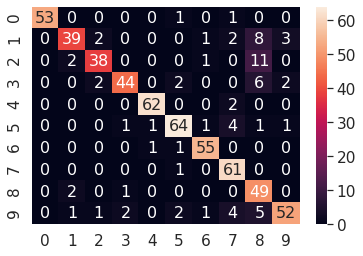

In [ ]:
model.confusion_matrix_plot(X_test, y_test)

The type of correlation we used for compute the mutual information 
$$\text{Pearson coefficient} = \frac{\sum (x - m_x) (y - m_y)}
             {\sqrt{\sum (x - m_x)^2) \sum (y - m_y)^2}}
$$